# Evaluation

In this notebook we pick up the result of our hyper parameter selection and evaluate the best model we could fine. 

The goal of the evaluation is twoffold:
1) Evaluate how good the model is at predicting pokemon types.
2) identify improvement potential that could be explored in future experiments.

In [22]:
# correct working directory only once 
if not "working_directory_corrected" in vars():
    %cd ..
    working_directory_corrected = True

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plot

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from models.Majority_Guessing_Benchmark import MajorityGuessingBenchmark
from evaluation.evaluation_metrics import EvaluationMetrics
from models.CNN_Builder import CNNBuilder
from data.dataset import Dataset
dataset = Dataset()


## Running the best model

Let's train the best model now. 
For training we use the same train-test split that has been used during the hyper-parameter selection (random state 7).

In [10]:
X, y = dataset.get_prepared_data()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 7)
y_train = np.array(object=[y_train[i] for i in range(len(y_train))])

train_datagen = ImageDataGenerator(
                            rotation_range=30, 
                            width_shift_range=0.1, 
                            height_shift_range=0.1, 
                            fill_mode="nearest"
                        )
train_generator = train_datagen.flow(X_train,y_train)

cnn_builder = CNNBuilder(
                            convolutional_layers=[16],
                            fully_connected_layers=[250],
                            in_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3]),
                            out_shape=y_train.shape[1]
                        )
model = cnn_builder.build_model()

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=20, restore_best_weights=True)
history = model.fit_generator(train_generator, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)

y_pred = model.predict(x=X_train) > 0.15
train_metrics = EvaluationMetrics(y_true=y_train, y_pred=y_pred)   # type: ignore

y_pred_test = model.predict(x=X_test) > 0.15
test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)    # type: ignore



C:\Users\frank\AppData\Local\Temp\ipykernel_24452\3567441712.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping], verbose=1)


Epoch 1/100
21/21 [==============================] - 6s 275ms/step - loss: 0.4232 - val_loss: 0.3610
Epoch 2/100
21/21 [==============================] - 6s 268ms/step - loss: 0.3412 - val_loss: 0.3108
Epoch 3/100
21/21 [==============================] - 6s 300ms/step - loss: 0.3070 - val_loss: 0.2891
Epoch 4/100
21/21 [==============================] - 6s 265ms/step - loss: 0.2935 - val_loss: 0.2794
Epoch 5/100
21/21 [==============================] - 6s 270ms/step - loss: 0.2870 - val_loss: 0.2760
Epoch 6/100
21/21 [==============================] - 5s 245ms/step - loss: 0.2844 - val_loss: 0.2729
Epoch 7/100
21/21 [==============================] - 5s 255ms/step - loss: 0.2828 - val_loss: 0.2720
Epoch 8/100
21/21 [==============================] - 6s 274ms/step - loss: 0.2817 - val_loss: 0.2726
Epoch 9/100
21/21 [==============================] - 6s 256ms/step - loss: 0.2809 - val_loss: 0.2734
Epoch 10/100
21/21 [==============================] - 5s 241ms/step - loss: 0.2810 - val_lo

Below we build a few dataframes that we will use for the comparisons

In [48]:
model = MajorityGuessingBenchmark(dataset.get_labels(), "Water")
y_pred_test = model.predict(X=X_test) # type: ignore
majority_test_metrics = EvaluationMetrics(y_true=y_test, y_pred=y_pred_test)  # type: ignore

score_dataframe = pd.DataFrame({ 
                        "model":["Majority Guessing", "CNN(training)","CNN(test)"],
                        "subset accuracy":[majority_test_metrics.subset_accuracy, train_metrics.subset_accuracy, test_metrics.subset_accuracy],
                        "hamming score":[majority_test_metrics.hamming_score, train_metrics.hamming_score, test_metrics.hamming_score]
                        })


f1_dataframe = pd.DataFrame(dataset.get_labels(),columns=["type"])
f1_dataframe["f1_train"] = train_metrics.f1_scores
f1_dataframe["f1_test"] = test_metrics.f1_scores
f1_dataframe["count"] = [np.count_nonzero(y_test[index] >0) for index in range(len(dataset.get_labels()))]

## Accuracy and Hamming Score
Here we observe the results we achieved with our model.

First, let's compare our scores against the naive benachmark of majority guessing:


In [50]:
score_dataframe[score_dataframe["model"].isin(["Majority Guessing","CNN(test)"])]

,model,subset accuracy,hamming score
0,Majority Guessing,9,0.14
2,CNN(test),8,0.18


TODO: Discuss comparison

## F1 Scores

Here we look at the F1 scores class by class to get some insights into how our model performs in the respective classes.

First off, let's look at the F1 scores for each type of pokemon and also observe how often this image is contained in the test set. 

In [57]:
f1_dataframe.drop(labels=["f1_train"], axis = 1, inplace=False)

,type,f1_test,count
0,Bug,0.206897,1
1,Dark,0.000000,2
2,Dragon,0.142857,2
3,Electric,0.000000,2
4,Fairy,0.000000,1
5,Fighting,0.000000,1
6,Fire,0.322581,1
7,Flying,0.058824,2
8,Ghost,0.000000,1
9,Grass,0.514286,2


As can be seen, each class is contained in the test set but only with a low number of samples. This is due to the small size of our dataset. 

The F1 scores of the respective classes are diverse. Visualized in a bar plot, they look like this: 

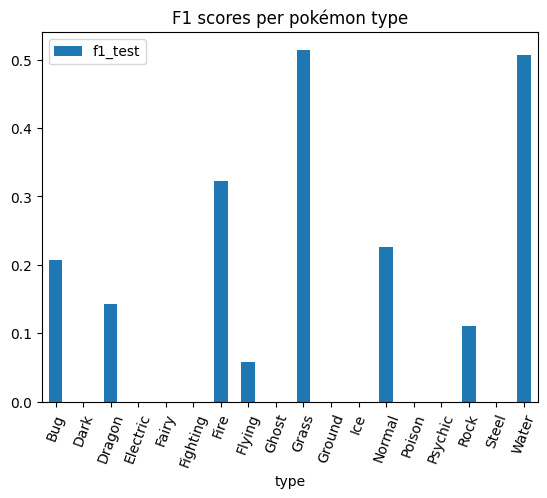

In [59]:
f1_dataframe.plot.bar(x="type", y=["f1_test"], rot=70, title="F1 scores per pokémon type");
plot.show(block=True);

TODO: interpret graphs

## Overfitting
Here we observe, whether our model exhibits overfitting. For this purpose, we compare the results on training and test set. 

Below, we compare the scores between our training and test set.

In [60]:
score_dataframe

,model,subset accuracy,hamming score
0,Majority Guessing,9,0.14
1,CNN(training),11,0.23
2,CNN(test),8,0.18


TODO: Discuss

In the below cell we plot the F1 scores for each class for training and test set.

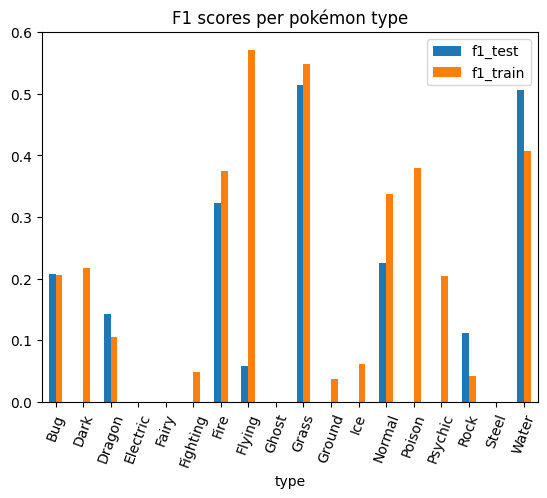

In [62]:
f1_dataframe.plot.bar(x="type", y=["f1_test", "f1_train"], rot=70, title="F1 scores per pokémon type");
plot.show(block=True);

TODO: discussion

Our training process was configured to return the model at the optimal state for the test scores. This means, if the model overfit to the training set after ths point, it is not reflected in the above scores. To have a chance to observe this, our training was configured to run for 25 steps after the best test loss. 

Below is a comparision of the training and test loss over the whole training duration:

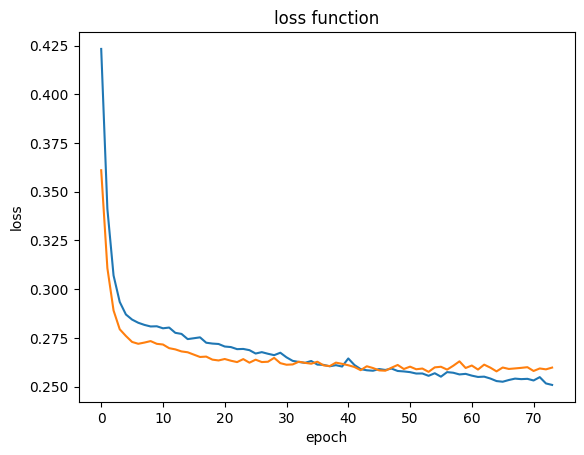

In [64]:
# plot training history
plot.plot(history.history["loss"], label="training loss")
plot.plot(history.history["val_loss"], label="test loss")
plot.title("loss function")
plot.ylabel("loss")
plot.xlabel("epoch")
plot.show()

TODO: Discuss 

TODO: conclusions on Overfitting.

## Conclusions

TODO: conclusions.